In [2]:
# imports and configuration

# uncomment to use a custom environment file
# from dotenv import load_dotenv
# load_dotenv('../main.env')

import os
from pathlib import Path

MODELS_PATH = Path(os.getenv('MODELS_PATH'))
DATA_PATH = Path(os.getenv('DATA_PATH'))
TORCH_HOME = Path(os.getenv('TORCH_HOME'))

print(f'{MODELS_PATH=}')
print(f'{DATA_PATH=}')
print(f'{TORCH_HOME=}')

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchinfo import summary

import torchvision.transforms.v2 as transforms
from torchvision.datasets import MNIST

from introdl.utils import get_device, load_results, load_model, summarizer
from introdl.idlmam import train_network
from introdl.visul import plot_training_metrics, vis_feature_maps, vis_feature_maps_widget, interactive_mnist_prediction

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [8, 6]  # Set the default figure size (width, height) in inches

MODELS_PATH=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/models')
DATA_PATH=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/data')
TORCH_HOME=WindowsPath('C:/Users/bagge/My Drive/Python_Projects/DS776_Develop_Project/downloads')


# Convolutional Neural Network for MNIST Digit Classification

In this notebook we implement the LeNet-5 network and apply it to the task of handwritten digit classification.  

LeNet-5 is one of the early convolutional neural networks (CNNs) that played a role in the development of deep learning. It was introduced by Yann LeCun in 1998 and was primarily designed for handwritten digit recognition tasks, such as classifying digits in the MNIST dataset. LeNet-5 consists of several layers, including convolutional layers, pooling layers, and fully connected layers. It demonstrated the effectiveness of CNNs in image classification tasks and laid the foundation for more advanced architectures in the field of deep learning.  Here is the original paper introducing LeNet-5 - ["Gradient-Based Learning Applied to Document Recognition"](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf).

We've already covered the basics of grayscale images and using the MNIST dataset in our previous notebook so we'll dive right in.

## Setup the data

In [3]:
mean = (0.1307,)
std = (0.3081,)

# Define transformations for the training and test sets
transform = transforms.Compose([
    transforms.ToImage(),                             # Convert to tensor without scaling
    transforms.ToDtype(torch.float32, scale = True),  # Scale to [0,1]
    transforms.Normalize(mean,std)        # Normalize with mean and std of MNIST dataset
])

# Download and load the training dataset
train_dataset = MNIST(root=DATA_PATH, train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# Download and load the test dataset
test_dataset = MNIST(root=DATA_PATH, train=False, download=True, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

## Define the model

The input to the LeNet-5 model is a 32x32 grayscale image. However, in the case of the MNIST dataset, the images are 28x28 grayscale. To make the dimensions consistent with the original model, a padding of two pixels is added around the 28x28 images.

The LeNet-5 model starts with a convolutional layer that applies a set of filters to the input image, extracting features such as edges and textures. This is followed by a pooling layer that reduces the spatial dimensions of the features while preserving their important information.

The process of alternating between convolutional and pooling layers is repeated twice to extract higher-level features from the input image. The extracted features are then flattened and passed through fully connected layers, which perform classification based on the learned features.

In [4]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 14*14
            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 5*5
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )
        
    def forward(self, x):
        return self.classifier(self.cnn_layers(x))

# Create an instance of the LeNet-5 model
model = LeNet5()

## Model Summary

As you can see in the summary below, LeNet-5 has 61,706 adjustable parameters while our previous fully-connected network applied to MNIST had 109,386 parameters.  If the performance of our CNN model is comparable, then we're doing something right!

In [5]:
summarizer(model, input_size = (64,1,28,28))

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #
LeNet5                                   [64, 1, 28, 28]      [64, 10]             --
├─Sequential: 1-1                        [64, 1, 28, 28]      [64, 16, 5, 5]       --
│    └─Conv2d: 2-1                       [64, 1, 28, 28]      [64, 6, 28, 28]      156
│    └─Tanh: 2-2                         [64, 6, 28, 28]      [64, 6, 28, 28]      --
│    └─AvgPool2d: 2-3                    [64, 6, 28, 28]      [64, 6, 14, 14]      --
│    └─Conv2d: 2-4                       [64, 6, 14, 14]      [64, 16, 10, 10]     2,416
│    └─Tanh: 2-5                         [64, 16, 10, 10]     [64, 16, 10, 10]     --
│    └─AvgPool2d: 2-6                    [64, 16, 10, 10]     [64, 16, 5, 5]       --
├─Sequential: 1-2                        [64, 16, 5, 5]       [64, 10]             --
│    └─Flatten: 2-7                      [64, 16, 5, 5]       [64, 400]            --
│    └─Linear: 2-8                       [64,

## Setup training

We're going to cheat a bit here and use a variant of gradient descent called the AdamW optimizer.  We'll talk more about optimizers in Lesson 3, but it would be a shame to wait until then to use it because it's much more efficient than vanilla gradient descent.

In [6]:
loss_func = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.AdamW(model.parameters(), lr=0.001)  # Adam optimizer

device = get_device()
print(device)

ckpt_file = MODELS_PATH / 'L02_MNIST_LeNet5.pt'
epochs = 10

score_funcs = {'ACC':accuracy_score}

cuda


## Train

In [7]:
results_MNIST_LeNet5 = train_network(model,
                                 loss_func,
                                 train_loader,
                                 device=device,
                                 test_loader=test_loader,
                                 epochs = epochs,
                                 optimizer = optimizer,
                                 score_funcs = score_funcs,
                                 checkpoint_file=ckpt_file)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 100%|██████████| 10/10 [02:08<00:00, 12.85s/it, test_loss=0.0396, train_loss=0.0163]


## Results

We trained for 10 epochs to give the optimizer an opportunity to converge completely, but very little progress is made on the test data after 5 or 6 epochs.  Amazingly we're at nearly 99% accuracy on the test set with a model that has fewer parameters than the fully-connected network we used in the previous notebook.  

It's often said that CNNs have **inductive bias** which refers to the assumptions built into the network architecture that help it generalize.  For CNNs, these biases include:

1. **Locality**: CNNs assume that important patterns in data (like edges in images) are localized, meaning nearby pixels are more related to each other than distant ones. This is captured by using convolutional filters that operate on small regions of the image.
  
2. **Translation Invariance**: CNNs are designed to recognize patterns, such as objects in an image, regardless of their position. Pooling layers help achieve this by summarizing information across small regions, reducing the sensitivity to exact object location.

The inductive biases included in LeNet-5 allow it to outperform a fully-connected network with even more parameters.

In [8]:
ckpt_file = MODELS_PATH / 'L02_MNIST_LeNet5.pt'
results_MNIST_LeNet5 = load_results(ckpt_file)

results_MNIST_LeNet5

,epoch,total time,train loss,test loss,train ACC,test ACC
0,0,8.086780,0.252951,0.089658,0.926250,0.9725
1,1,20.259460,0.076023,0.063577,0.976950,0.9800
2,2,32.528419,0.052680,0.046724,0.983633,0.9837
3,3,44.809271,0.040465,0.045771,0.987583,0.9859
4,4,57.150367,0.033294,0.044909,0.989667,0.9858
5,5,69.452744,0.027095,0.039295,0.991283,0.9881
6,6,81.779808,0.022668,0.055425,0.992850,0.9824
7,7,93.499990,0.021019,0.042505,0.993367,0.9871
8,8,105.596112,0.017977,0.045852,0.994400,0.9861
9,9,117.766254,0.016295,0.039649,0.994667,0.9878


You can also view the results graphically if you would prefer.

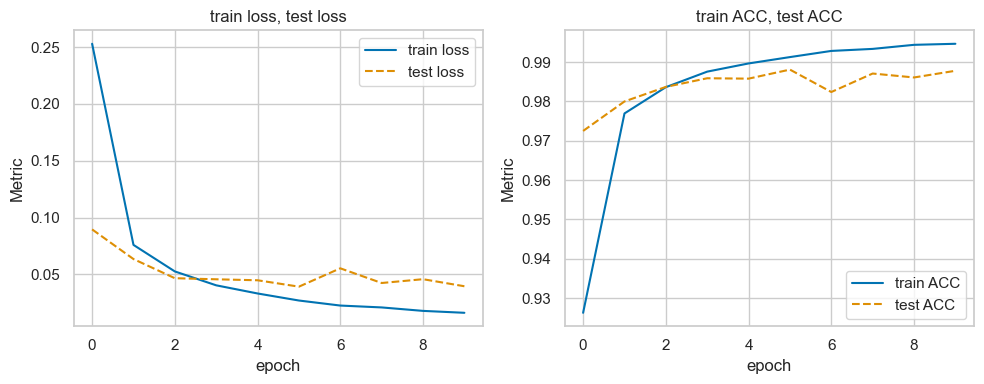

In [9]:
plot_training_metrics(results_MNIST_LeNet5,  [['train loss', 'test loss'], ['train ACC', 'test ACC']])

Let's compare the training metrics to those from the fully-connected network we trained on MNIST in the previous notebook.

In the plot below we'll show only the loss and accuracy for the test set for both the Fully-Connected network and the CNN from this notebook.

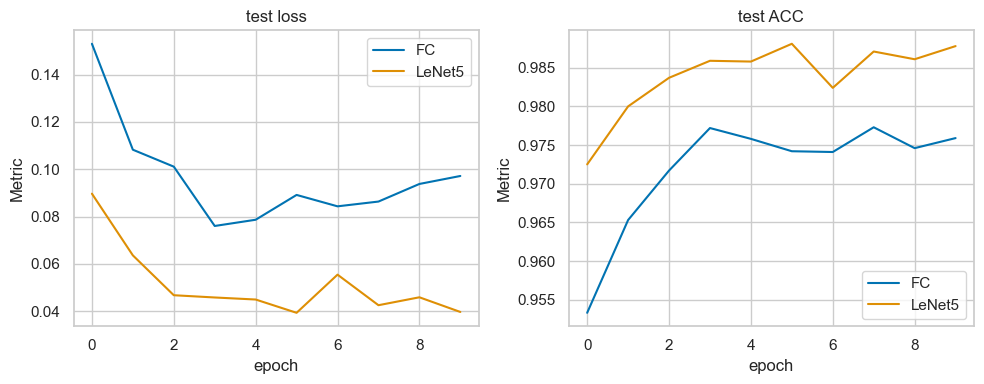

In [11]:
ckpt_file = MODELS_PATH / 'L02_MNIST_FC.pt'
results_MNIST_FC = load_results(ckpt_file)

plot_training_metrics([results_MNIST_FC,results_MNIST_LeNet5],  [['test loss'], ['test ACC']],df_labels=['FC','LeNet5'])

We can see that the LeNet5 model performs slightly better even though it has fewer parameters than the fully connected network.  This is because the convolutional network is specially designed for image data (it has *inductive bias*).

## Visualizing the Feature Maps

These are the outputs of the convolutional layers.  We've set up a little widget for viewing the features after each convolutional layer.  These are displayed with a Purple-Orange colormap.  Purple represents positive value and orange represents negative values.  White represents zero.

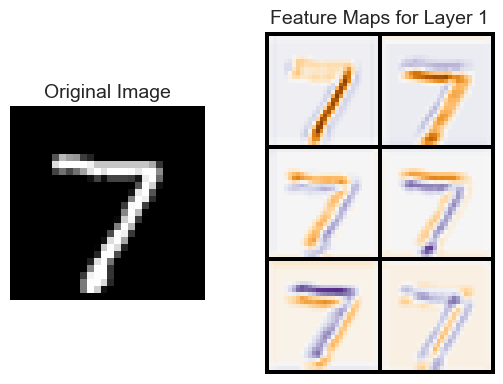

In [12]:
from introdl.utils import load_model

ckpt_file = MODELS_PATH / 'L02_MNIST_LeNet5.pt'
model = load_model(LeNet5, ckpt_file)

vis_feature_maps_widget(model=model, dataset=test_dataset, initial_target_index=0, mean=mean, std=std,
                    original_image_size=(2,2),feature_maps_size=(4,4))

If widgets won't run in your notebook, you can all `visualize_feature_maps` directly as in the cell below.  You could also execute `?visualize_feature_maps` to see all the options.

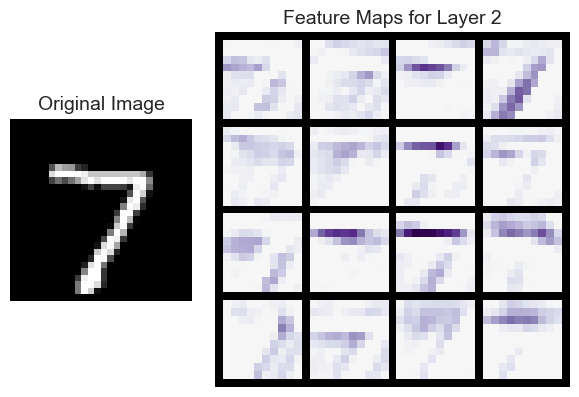

In [ ]:
vis_feature_maps(model=model, dataset=test_dataset, target_index=0, layer = 2, activation='relu', mean=mean, std=std,
                    original_image_size=(2,2),feature_maps_size=(4,4))

## A Common Principle of CNN Design

In CNN design, a common principle is to **increase the number of features (channels) as we reduce the spatial resolution** of the feature maps. Here’s why this is effective in CNNs:

1. **Retaining Information**: As we progress deeper into a CNN, spatial details (e.g., exact pixel locations) become less critical, and the model focuses on higher-level patterns or features (e.g., edges, textures, shapes). By increasing the number of channels, we compensate for the reduced spatial resolution by allowing the network to capture more abstract and complex patterns.

2. **Efficient Computation**: Reducing spatial resolution through pooling or using a stride greater than 1 cuts down on computational cost by decreasing the number of pixels the model needs to process. Increasing the number of channels at the same time keeps the network expressive enough without making it overly large or computationally expensive.

3. **Hierarchy of Features**: Early layers capture fine, local details over larger spatial dimensions, but as we go deeper, the network should learn more abstract, global patterns. By shrinking spatial resolution while expanding channels, the network progressively learns features that are both broader and more complex.

In LeNet-5, as the model progresses:

1. **The number of channels increases** (from 1 to 6, then 16, and finally 120), enabling the network to capture richer, more complex information.
2. **The spatial resolution decreases** (from 32x32 to 5x5), focusing the model’s capacity on high-level features rather than precise spatial details.

## LeNet5 Revised

Modern CNNs tend to use max pooling instead of average pooling so we'll try that here.  Moreover, the hyperbolic tangent activation functions are usually replaced by ReLU activations (or one of its variants) to improve network performance and training.  You'll learn more about better activation functions in Lesson 4.  

For now, we've added those changes to LeNet-5 as a preview to see if the performance increases.

In [13]:
class LeNet5Rev(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14*14
            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 5*5
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )
        
    def forward(self, x):
        return self.classifier(self.cnn_layers(x))

# Create an instance of the LeNet-5 model
model = LeNet5Rev()

In [14]:
loss_func = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
device = get_device()

ckpt_file = MODELS_PATH / 'L02_MNIST_LeNet5Rev.pt'
epochs = 10

from sklearn.metrics import accuracy_score
score_funcs = {'ACC':accuracy_score}

results_MNIST_LeNet5Rev = train_network(model,
                                    loss_func,
                                    train_loader,
                                    device=device,
                                    test_loader=test_loader,
                                    epochs=epochs,
                                    optimizer=optimizer,
                                    score_funcs=score_funcs,
                                    checkpoint_file=ckpt_file)

results_MNIST_LeNet5Rev

Epoch: 100%|██████████| 10/10 [02:14<00:00, 13.47s/it, test_loss=0.0318, train_loss=0.0131]


,epoch,total time,train loss,test loss,train ACC,test ACC
0,0,12.535300,0.218785,0.063815,0.932383,0.9814
1,1,24.882453,0.060512,0.042819,0.981583,0.9853
2,2,37.547706,0.043592,0.042571,0.986167,0.9869
3,3,49.837721,0.034503,0.035230,0.989500,0.9884
4,4,62.299639,0.028730,0.033319,0.990550,0.9882
5,5,74.627941,0.021839,0.035440,0.993183,0.9881
6,6,86.949029,0.020445,0.028915,0.993583,0.9917
7,7,98.886901,0.017893,0.031582,0.994400,0.9898
8,8,111.610860,0.014682,0.044231,0.995317,0.9867
9,9,124.034709,0.013094,0.031768,0.995667,0.9892


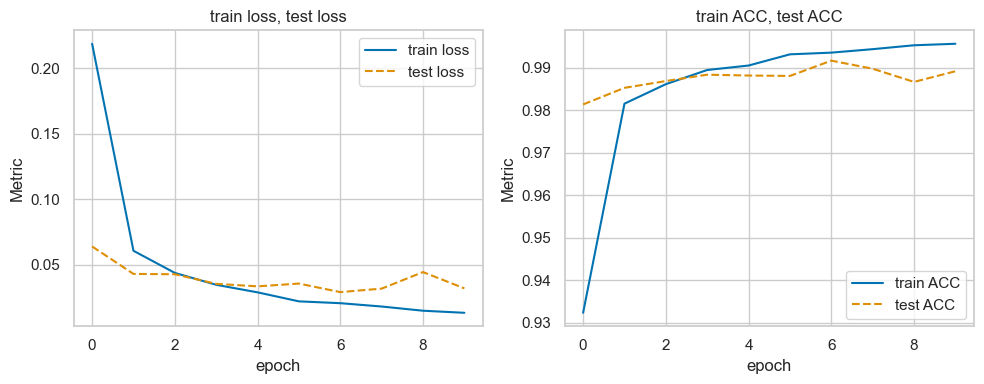

In [15]:
results_MNIST_LeNet5Rev=load_results(MODELS_PATH / 'L02_MNIST_LeNet5Rev.pt')
plot_training_metrics(results_MNIST_LeNet5Rev,  [['train loss', 'test loss'], ['train ACC', 'test ACC']])

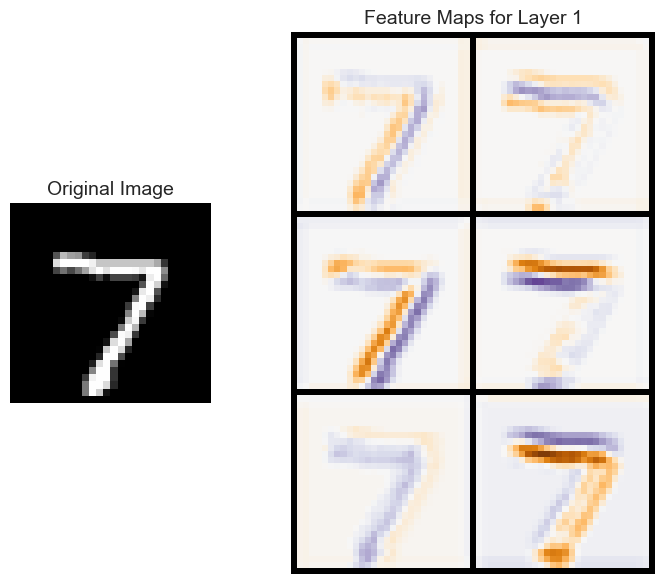

In [16]:
ckpt_file = MODELS_PATH / 'L02_MNIST_LeNet5Rev.pt'
model = load_model(LeNet5Rev, ckpt_file)

vis_feature_maps_widget(model=model, dataset=test_dataset, initial_target_index=0, mean=mean, std=std,
                    original_image_size=(2,2),feature_maps_size=(6,6))

### Evaluating the Model

Nearly 99% accuracy!  Like we did with the Fully Connect MNIST model, we'll look at the confusion matrix and some of the misclassified digits.

Total number of images: 10000
Number of misclassified images: 108


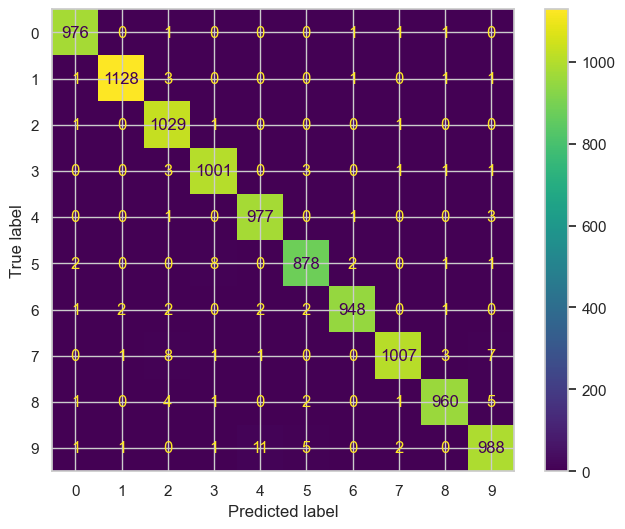

In [17]:
device = get_device()
model = load_model(LeNet5Rev, MODELS_PATH / 'L02_MNIST_LeNet5Rev.pt', device)

# Set the model to evaluation mode
model.eval()

# Collect the labels, predicted labels, and misclassified images
labels = []
pred_labels = []
misclassified_images = []
misclassified_true_labels = []
misclassified_pred_labels = []

# Iterate over the test dataset
for images, targets in test_loader:
    # Move the images and targets to the device
    images = images.to(device)
    targets = targets.to(device)
    
    # Forward pass
    outputs = model(images)
    
    # Get the predicted labels
    _, predicted = torch.max(outputs.data, 1)
    
    # Append the labels and predicted labels to the lists
    labels.extend(targets.cpu().numpy())
    pred_labels.extend(predicted.cpu().numpy())
    
    # Collect misclassified images
    for i in range(len(targets)):
        if targets[i] != predicted[i]:
            misclassified_images.append(images[i].cpu().numpy())
            misclassified_true_labels.append(targets[i].item())
            misclassified_pred_labels.append(predicted[i].item())

# Print the total number of images and the number of misclassified images
total_images = len(labels)
num_misclassified = len(misclassified_images)
print(f'Total number of images: {total_images}')
print(f'Number of misclassified images: {num_misclassified}')

# Compute the confusion matrix
confusion_mat = confusion_matrix(labels, pred_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_mat)
disp.plot()
plt.show()

It's a good idea to look at the images that are misclassified.  Running the cell below will display 25 misclassified digits selected at random.  Are you surprised by any of the misclassifications? Run the cell repeatedly to see different samples of misclassified digits.

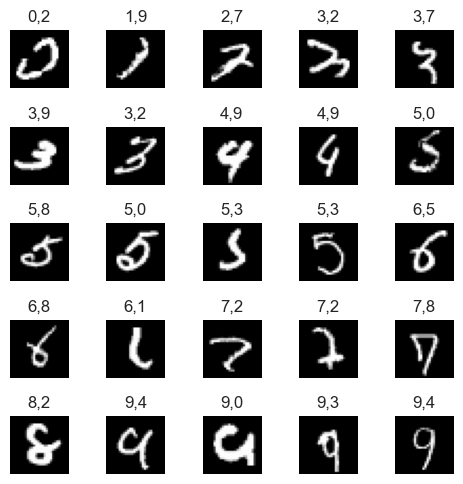

In [18]:
# Plot a random sample of 25 misclassified images (or fewer if there aren't 25), ordered by true label
num_images_to_plot = min(25, num_misclassified)
random_indices = np.random.choice(num_misclassified, num_images_to_plot, replace=False)

# Sort the selected misclassified images by their true labels
sorted_indices = sorted(random_indices, key=lambda i: misclassified_true_labels[i])

num_cols = 5
num_rows = (num_images_to_plot + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, num_rows))
axes = axes.flatten()

for i in range(num_rows * num_cols):
    if i < num_images_to_plot:
        idx = sorted_indices[i]
        image = misclassified_images[idx].squeeze()  # Remove channel dimension if present
        true_label = misclassified_true_labels[idx]
        pred_label = misclassified_pred_labels[idx]
        
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'{true_label},{pred_label}')
        axes[i].axis('off')
    else:
        axes[i].axis('off')

plt.tight_layout()
plt.show()

## Just for fun

Run the cell below to get a widget that allows you draw digits and make predictions using your model.  The hand drawn digit gets cropped, "thickened", and resized to 28x28 pixels before being fed to the model.  It works surprisingly well, but it's also not too difficult to draw digits that it will misclassify.  It's far from perfect - our "images" are black and white instead of grayscale, but it's fun to play around a bit.  Enjoy!

In [19]:
ckpt_file = MODELS_PATH / 'L02_MNIST_LeNet5Rev.pt'
model = load_model(LeNet5Rev, ckpt_file)

interactive_mnist_prediction(model)